# EDA - The Refiner 🚦
## Valencia Traffic Platform

En esta etapa realizaremos el Análisis Exploratorio de Datos (EDA) del histórico acumulado. 

### Referencia API Valencia
Es crucial notar que el mapeo de estados es distinto al de Barcelona:
- **0**: Fluido
- **1**: Denso
- **2**: Muy denso
- **3**: Congestión
- **5**: Cortado
- **9**: Sin datos

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Añadir src al path para importar el data_loader
sys.path.append(os.path.abspath("../"))
from src.refining.data_loader import load_historical_data

### 1. Carga de Datos Históricos
Cargamos todos los JSON descargados del VPS.

In [2]:
df = load_historical_data("../data/raw/2025")
df.head()

2025-12-26 18:32:29,567 - INFO - Loading 734 files from ../data/raw/2025...
2025-12-26 18:32:34,578 - ERROR - Error processing ..\data\raw\2025\12\22\traffic_230005.json: Expecting ',' delimiter: line 4106 column 30 (char 98282)
2025-12-26 18:32:34,842 - INFO - Total records loaded: 75958
2025-12-26 18:32:34,843 - INFO - Columns found: ['gid', 'denominacion', 'estado', 'idtramo', 'geo_shape', 'geo_point_2d', 'geo_shape.type', 'geo_shape.geometry.coordinates', 'geo_shape.geometry.type', 'geo_point_2d.lon', 'geo_point_2d.lat', 'ingested_at']


,gid,denominacion,estado,idtramo,geo_shape,geo_point_2d,geo_shape.type,geo_shape.geometry.coordinates,geo_shape.geometry.type,geo_point_2d.lon,geo_point_2d.lat,ingested_at
0,2263,None,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-12-08 17:34:22.420062
72,2043,DOCTOR LLUCH HACIA NARANJOS,0.0,247.0,NaN,NaN,Feature,"[[-0.3289445617403896, 39.46320593733645], [-0...",LineString,-0.328628,39.465357,2025-12-08 17:34:22.420062
71,2194,MANUEL DE FALLA,0.0,208.0,NaN,NaN,Feature,"[[-0.39963670538363966, 39.47573083399886], [-...",LineString,-0.402612,39.475205,2025-12-08 17:34:22.420062
70,2131,A-3 SENTIDO SALIDA,0.0,339.0,NaN,NaN,Feature,"[[-0.41565369798294255, 39.469514876321405], [...",LineString,-0.418271,39.469421,2025-12-08 17:34:22.420062
69,1901,FERRAN EL CATOLIC CAP A PONT DE LAS GLORIES VA...,0.0,30.0,NaN,NaN,Feature,"[[-0.3841299016122036, 39.469399716316545], [-...",LineString,-0.386995,39.473379,2025-12-08 17:34:22.420062


### 2. Preprocesamiento (Lecciones del TFM)

Aplicamos el redondeo a 5 minutos y limpieza de nulos.

In [3]:
# Convertir ingestion_at a datetime
df['dt'] = pd.to_datetime(df['ingestion_at'])

# Redondeo a 5 minutos (esencial para alinear series temporales)
df['dt_rounded'] = df['dt'].dt.round('5min')

# Extraer características temporales
df['hour'] = df['dt_rounded'].dt.hour
df['day_of_week'] = df['dt_rounded'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

# Eliminar registros sin datos (estado 9 en Valencia)
df_clean = df[df['estado'] != 9].copy()

print(f"Registros originales: {len(df)}")
print(f"Registros tras limpieza: {len(df_clean)}")

KeyError: 'ingestion_at'

### 3. Análisis de Distribución de Estados
Visualizamos el desbalanceo de clases.

2025-12-26 18:18:36,898 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-12-26 18:18:36,939 - INFO - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


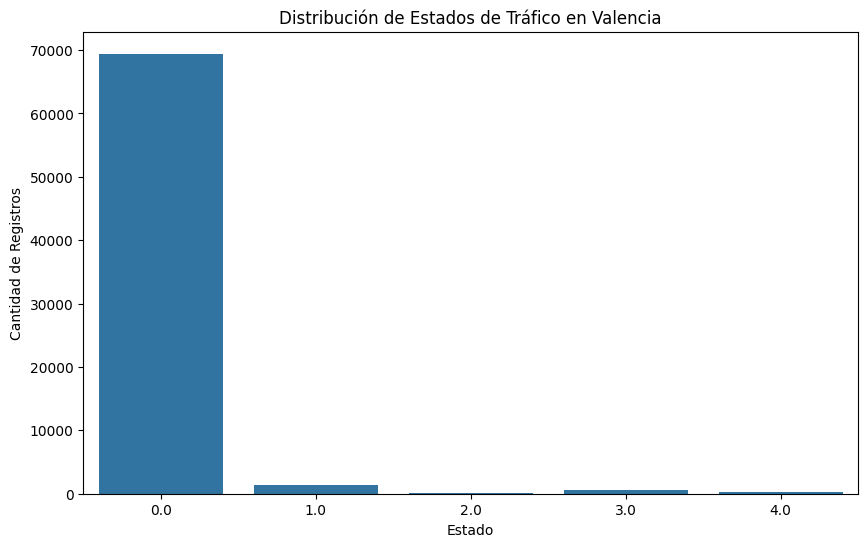

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df_clean, x='estado')
plt.title('Distribución de Estados de Tráfico en Valencia')
plt.xlabel('Estado')
plt.ylabel('Cantidad de Registros')
plt.show()

### 4. Análisis Temporal Detallado
¿A qué horas ocurren los estados de congestión (1, 2, 3)?

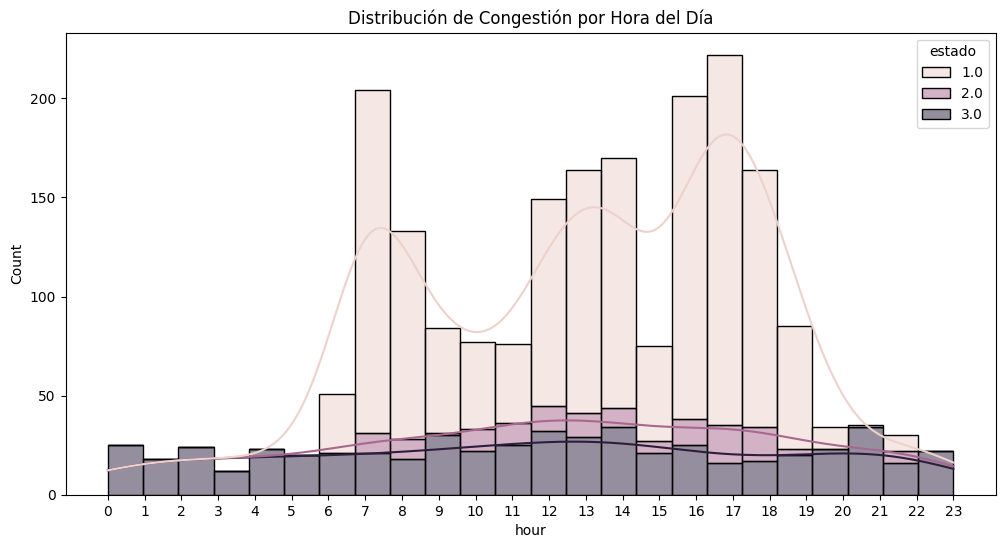

In [ ]:
# Filtrar solo tráfico no fluido para ver el patrón de atascos
df_traffic = df_clean[df_clean['estado'].isin([1, 2, 3])]

if not df_traffic.empty:
    plt.figure(figsize=(12, 6))
    sns.histplot(data=df_traffic, x='hour', bins=24, kde=True, hue='estado', multiple='stack')
    plt.title('Distribución de Congestión por Hora del Día')
    plt.xticks(range(0, 24))
    plt.show()
else:
    print("No hay registros de congestión en esta muestra para graficar.")

### 5. Feature Engineering: Variables Cíclicas
Las horas (23 -> 0) y los días (6 -> 0) son cíclicos.

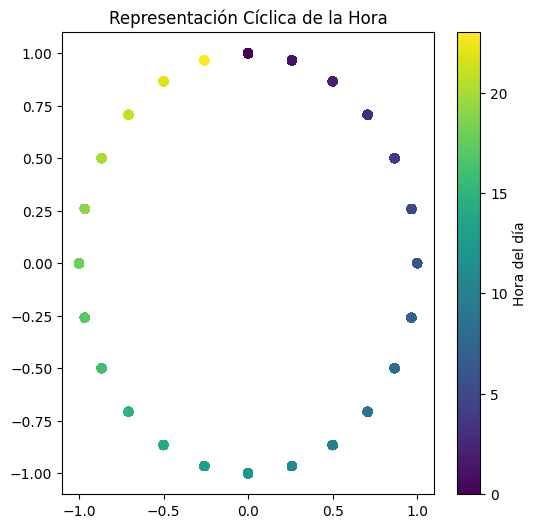

In [ ]:
def encode_cyclical(df, col, max_val):
    df[col + '_sin'] = np.sin(2 * np.pi * df[col] / max_val)
    df[col + '_cos'] = np.cos(2 * np.pi * df[col] / max_val)
    return df

df_clean = encode_cyclical(df_clean, 'hour', 24)
df_clean = encode_cyclical(df_clean, 'day_of_week', 7)

# Visualización del círculo
plt.figure(figsize=(6, 6))
plt.scatter(df_clean['hour_sin'], df_clean['hour_cos'], c=df_clean['hour'], cmap='viridis')
plt.title('Representación Cíclica de la Hora')
plt.colorbar(label='Hora del día')
plt.show()

### 6. Feature Engineering: Lag Features (Retardos)
Creamos retardos de 5, 10 y 15 minutos por tramo (`idtramo`).

In [ ]:
# Ordenar por tramo y tiempo para asegurar retardos correctos
df_clean = df_clean.sort_values(['idtramo', 'dt_rounded'])

# Crear retardos (Lag 1 = 5 min antes, Lag 2 = 10 min antes)
for lag in [1, 2, 3]:
    df_clean[f'estado_lag_{lag}'] = df_clean.groupby('idtramo')['estado'].shift(lag)

# Eliminar filas con NaN resultantes de los retardos
df_ml = df_clean.dropna(subset=['estado_lag_1', 'estado_lag_2', 'estado_lag_3'])

print(f"Dataset listo para ML con {df_ml.shape[1]} columnas.")
df_ml[['idtramo', 'dt_rounded', 'estado', 'estado_lag_1', 'estado_lag_2']].head(10)

Dataset listo para ML con 24 columnas.


,idtramo,dt_rounded,estado,estado_lag_1,estado_lag_2
32969,1.0,2025-12-17 07:00:00,1.0,1.0,1.0
33014,1.0,2025-12-17 07:10:00,1.0,1.0,1.0
33113,1.0,2025-12-17 07:20:00,1.0,1.0,1.0
33213,1.0,2025-12-17 07:30:00,1.0,1.0,1.0
33314,1.0,2025-12-17 07:40:00,1.0,1.0,1.0
33415,1.0,2025-12-17 07:50:00,1.0,1.0,1.0
33514,1.0,2025-12-17 08:00:00,1.0,1.0,1.0
33615,1.0,2025-12-17 08:10:00,1.0,1.0,1.0
34215,1.0,2025-12-17 09:10:00,1.0,1.0,1.0
34316,1.0,2025-12-17 09:20:00,1.0,1.0,1.0
